In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier # Redes Neurais (MLP)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Início do Notebook: Redes Neurais (vou usar o MLP {{Perceptron Multicamadas}}) ---")

--- Início do Notebook: Redes Neurais (vou usar o MLP {{Perceptron Multicamadas}}) ---


In [16]:
# 1. Carregando o dataset
try:
    df_walmart = pd.read_csv(r'data/Walmart.csv')
    print("Dataset 'Walmart.csv' carregado com sucesso!")
    print("\nPrimeiras 5 linhas do dataset:")
    print(df_walmart.head())
    print("\nInformações gerais do dataset antes do pré-processamento:")
    df_walmart.info()
except FileNotFoundError:
    print("Erro: O arquivo 'Walmart.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo esteja no mesmo diretório do seu script.")

Dataset 'Walmart.csv' carregado com sucesso!

Primeiras 5 linhas do dataset:
   invoice_id   Branch         City                category unit_price  \
0           1  WALM003  San Antonio       Health and beauty     $74.69   
1           2  WALM048    Harlingen  Electronic accessories     $15.28   
2           3  WALM067  Haltom City      Home and lifestyle     $46.33   
3           4  WALM064      Bedford       Health and beauty     $58.22   
4           5  WALM013       Irving       Sports and travel     $86.31   

   quantity      date      time payment_method  rating  profit_margin  
0       7.0  05/01/19  13:08:00        Ewallet     9.1           0.48  
1       5.0  08/03/19  10:29:00           Cash     9.6           0.48  
2       7.0  03/03/19  13:23:00    Credit card     7.4           0.33  
3       8.0  27/01/19  20:33:00        Ewallet     8.4           0.33  
4       7.0  08/02/19  10:37:00        Ewallet     5.3           0.48  

Informações gerais do dataset antes do pré-pr

In [17]:
# 2. Pré-processamento inicial
df_walmart['unit_price'] = df_walmart['unit_price'].astype(str).str.replace('$', '', regex=False).astype(float)

print("\nColuna 'unit_price' convertida para numérico.")


Coluna 'unit_price' convertida para numérico.


In [18]:
# 3. Criar a variável alvo (y) para Classificação
df_walmart['High_Rating'] = (df_walmart['rating'] >= 7).astype(int)

print("\nNova coluna 'High_Rating' (variável alvo) criada. Contagem de classes:")
print(df_walmart['High_Rating'].value_counts())



Nova coluna 'High_Rating' (variável alvo) criada. Contagem de classes:
High_Rating
0    6492
1    3559
Name: count, dtype: int64


In [19]:
# 4. Definir características (X) e a variável alvo (y) novamente
X = df_walmart.drop(['invoice_id', 'date', 'time', 'rating', 'High_Rating', 'City'], axis=1)
y = df_walmart['High_Rating']

# Identificar colunas numéricas e categóricas para o pré-processamento
numeric_features = ['unit_price', 'quantity', 'profit_margin']
categorical_features = ['category', 'payment_method', 'Branch']

print(f"\nCaracterísticas (X) selecionadas: {numeric_features + categorical_features}")
print(f"Variável alvo (y) selecionada: 'High_Rating'")


Características (X) selecionadas: ['unit_price', 'quantity', 'profit_margin', 'category', 'payment_method', 'Branch']
Variável alvo (y) selecionada: 'High_Rating'


In [20]:
# 5. Tratamento de valores ausentes em X antes do ColumnTransformer
for col in numeric_features:
    if X[col].isnull().any():
        mean_val = X[col].mean()
        X[col].fillna(mean_val, inplace=True)
        print(f"Valores ausentes na coluna numérica '{col}' preenchidos com a média.")

for col in categorical_features:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        print(f"Valores ausentes na coluna categórica '{col}' preenchidos com o modo.")


Valores ausentes na coluna numérica 'unit_price' preenchidos com a média.
Valores ausentes na coluna numérica 'quantity' preenchidos com a média.


C:\Users\Rafael\AppData\Local\Temp\ipykernel_4692\2959526550.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mean_val, inplace=True)


In [21]:
# 6. Criar um pré-processador usando ColumnTransformer e Pipeline
# como sempre o Standardscaler para colunas numéricas ** e é fundamental para para Redes Neurais!!!
# OneHotEncoder para colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [22]:
# 7.  treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nDados divididos: Treino={len(X_train)} amostras, Teste={len(X_test)} amostras.")
print(f"Proporção de 'High_Rating' no treino:\n{y_train.value_counts(normalize=True)}")
print(f"Proporção de 'High_Rating' no teste:\n{y_test.value_counts(normalize=True)}")



Dados divididos: Treino=7035 amostras, Teste=3016 amostras.
Proporção de 'High_Rating' no treino:
High_Rating
0    0.645913
1    0.354087
Name: proportion, dtype: float64
Proporção de 'High_Rating' no teste:
High_Rating
0    0.645889
1    0.354111
Name: proportion, dtype: float64


In [ ]:
# 8. Treinar e avaliar o modelo de Rede Neural (MLPClassifier)
# random_state: Para reprodutibilidade. (pode ser qlqr número inteiro)
mlp_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', MLPClassifier(hidden_layer_sizes=(100, 50),
activation='relu',
solver='adam',
max_iter=500, # 
random_state=27,
verbose=True))]) # verbose=True é pra poder ver o progresso do treinamento

print("\nTreinando o modelo de Rede Neural (MLPClassifier)...")
# em geral o treinamento de redes neurais demora um pouco mais
mlp_pipeline.fit(X_train, y_train)
print("Treinamento da Rede Neural concluído.")


Treinando o modelo de Rede Neural (MLPClassifier)...
Iteration 1, loss = 0.64130744
Iteration 2, loss = 0.61832468
Iteration 3, loss = 0.61177886
Iteration 4, loss = 0.60741692
Iteration 5, loss = 0.60236269
Iteration 6, loss = 0.59848258
Iteration 7, loss = 0.59439643
Iteration 8, loss = 0.59051268
Iteration 9, loss = 0.58565951
Iteration 10, loss = 0.58156294
Iteration 11, loss = 0.57621214
Iteration 12, loss = 0.57210514
Iteration 13, loss = 0.56684810
Iteration 14, loss = 0.56222339
Iteration 15, loss = 0.55774011
Iteration 16, loss = 0.55293289
Iteration 17, loss = 0.54773075
Iteration 18, loss = 0.54477747
Iteration 19, loss = 0.53768409
Iteration 20, loss = 0.53120617
Iteration 21, loss = 0.52688899
Iteration 22, loss = 0.52194532
Iteration 23, loss = 0.51736226
Iteration 24, loss = 0.51365673
Iteration 25, loss = 0.50771679
Iteration 26, loss = 0.50622682
Iteration 27, loss = 0.49716959
Iteration 28, loss = 0.49442865
Iteration 29, loss = 0.49474356
Iteration 30, loss = 0.4876

In [24]:
# Fazer previsões no conjunto de teste
y_pred_mlp = mlp_pipeline.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"\n--- Resultados da Rede Neural (MLP) ---")
print(f"Acurácia da Rede Neural no conjunto de teste: {accuracy:.4f}")

print("\nRelatório de Classificação (Precision, Recall, F1-score):")
print(classification_report(y_test, y_pred_mlp, target_names=['Baixa Avaliação (0)', 'Alta Avaliação (1)']))



--- Resultados da Rede Neural (MLP) ---
Acurácia da Rede Neural no conjunto de teste: 0.5978

Relatório de Classificação (Precision, Recall, F1-score):
                     precision    recall  f1-score   support

Baixa Avaliação (0)       0.68      0.71      0.70      1948
 Alta Avaliação (1)       0.43      0.39      0.41      1068

           accuracy                           0.60      3016
          macro avg       0.55      0.55      0.55      3016
       weighted avg       0.59      0.60      0.59      3016




Matriz de Confusão:
[[1386  562]
 [ 651  417]]


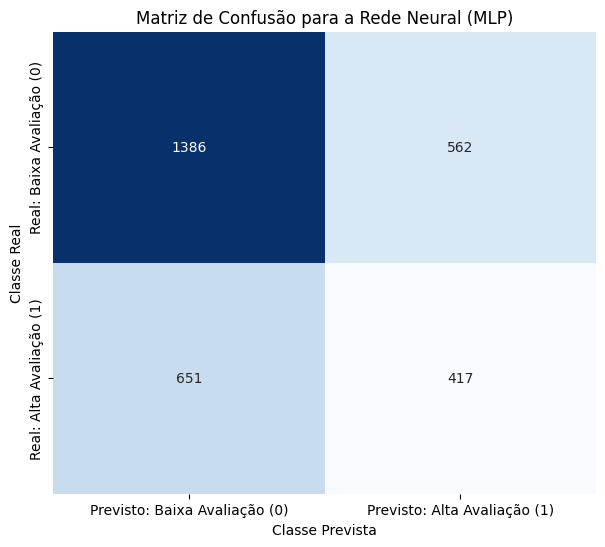

In [25]:
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_mlp)
print(cm)

# Visualização da Matriz de Confusão
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Previsto: Baixa Avaliação (0)', 'Previsto: Alta Avaliação (1)'],
            yticklabels=['Real: Baixa Avaliação (0)', 'Real: Alta Avaliação (1)'])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão para a Rede Neural (MLP)')
plt.show()


In [29]:
print("\n--- Exemplo de Nova Previsão com Rede Neural ---")

# valores hipotéticos
novo_dado_transacao_nn = pd.DataFrame({
    'unit_price': [91.0],                  
    'quantity': [3.0],                     
    'profit_margin': [0.40],               
    'category': ['Electronic accessories'], 
    'payment_method': ['Credit card'],     
    'Branch': ['A']                        
})

print("\nNovo dado de transação para previsão:")
print(novo_dado_transacao_nn)

# Fazer a previsão usando o pipeline treinado
previsao_bruta_nn = mlp_pipeline.predict(novo_dado_transacao_nn)
predicted_class_nn = 'Alta Avaliação' if previsao_bruta_nn[0] == 1 else 'Baixa Avaliação'
print(f"O modelo de Rede Neural previu que esta transação terá uma: {predicted_class_nn}")



--- Exemplo de Nova Previsão com Rede Neural ---

Novo dado de transação para previsão:
   unit_price  quantity  profit_margin                category payment_method  \
0        91.0       3.0            0.4  Electronic accessories    Credit card   

  Branch  
0      A  
O modelo de Rede Neural previu que esta transação terá uma: Alta Avaliação
